###Adding libraries 

In [17]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
%matplotlib inline

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

###Set a Dataset

In [2]:
titanic_data = pd.read_csv('F:\\train.csv')

In [3]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###Data preprocessing

In [4]:
X = titanic_data.drop(['PassengerId' , 'Survived' , 'Name' , 'Ticket' , 'Cabin'], axis=1)
y = titanic_data.Survived

###Filling blank lines

In [5]:
X = X.fillna({'Age': X.Age.median()})

###Representation of lines with words in lines with numbers

In [6]:
X = pd.get_dummies(X)

###Dividing data into a training group and a test group

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#########1 training option: manually selecting parameters

###List with the maximum value of tree depth

In [56]:
max_depth_values = range(1, 50)

###Training data will be stored in DataFrame

In [57]:
scores_data = pd.DataFrame()

###Training trees with different tree depths and with cross validation

In [58]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= max_depth)
    clf.fit(X_train , y_train)
    trains_score =  clf.score(X_train , y_train)
    test_score = clf.score(X_test , y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'trains_score': [trains_score],
                                    'test_score': [test_score],
                                   'cross_val_score': [mean_cross_val_score]})
    
    scores_data = scores_data.append(temp_score_data)

In [59]:
scores_data.head()

,max_depth,trains_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.806780,0.802073


In [60]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['trains_score', 'test_score', 'cross_val_score'],
                           var_name='set_type', value_name='score')

In [61]:
scores_data_long.head()

,max_depth,set_type,score
0,1,trains_score,0.781879
1,2,trains_score,0.805369
2,3,trains_score,0.823826
3,4,trains_score,0.833893
4,5,trains_score,0.840604


###Cross validation for each depth

In [62]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)

,max_depth,set_type,score
98,1,cross_val_score,0.781961
99,2,cross_val_score,0.770196
100,3,cross_val_score,0.790322
101,4,cross_val_score,0.788627
102,5,cross_val_score,0.802073
103,6,cross_val_score,0.800392
104,7,cross_val_score,0.798697
105,8,cross_val_score,0.802045
106,9,cross_val_score,0.800350
107,10,cross_val_score,0.807073


###Presentation of learning results in graph form

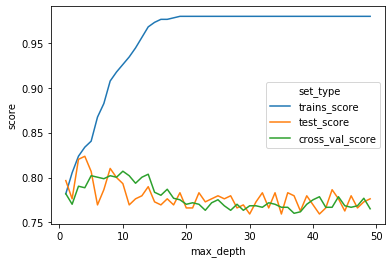

In [63]:
sns.lineplot(x= "max_depth", y= "score", hue= "set_type", data=scores_data_long)

###Choosing the best tree depth according to cross validation

In [135]:
best_clf = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 6, min_samples_split= 50)

In [136]:
best_clf.fit(X_train , y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [137]:
cross_val_score(best_clf, X_test, y_test, cv=5).mean()

0.776271186440678

###Decision tree

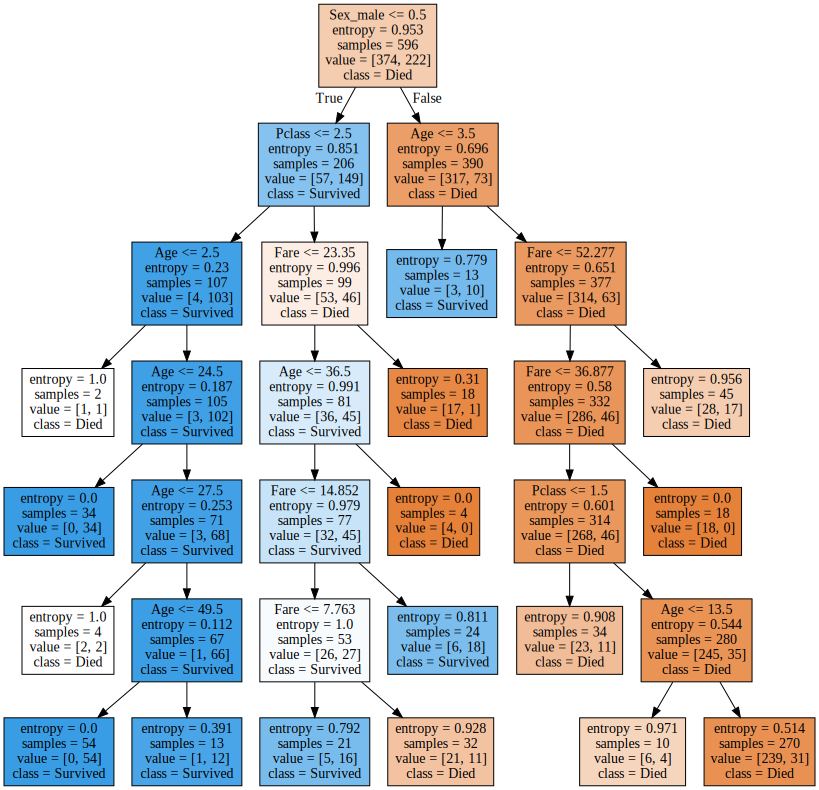

In [138]:
graph = Source(tree.export_graphviz(best_clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Died','Survived'],
                                   filled = True))

display(SVG(graph.pipe(format='svg')))

#########2 training option: using of GridSearchCV

In [121]:
clf = tree.DecisionTreeClassifier()

In [122]:
parametrs = {'criterion': ['gini', 'entropy'],
             'max_depth': range(1, 30),
             'min_samples_split': range(2, 100),}

###Choosing the most suitable options

In [123]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

###Tree training

In [124]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [125]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 40}

In [126]:
best_clf = grid_search_cv_clf.best_estimator_

###Class accuracy

In [127]:
best_clf.score(X_test, y_test)

0.7796610169491526

In [128]:
y_predicted_prob = best_clf.predict_proba(X_test)

###Titanic passengers with a probability of survival greater than 0.7 are classified as living, the rest as dead

In [129]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.7, 1, 0 )

###Calculation of precision metric

In [130]:
precision_score(y_test, y_pred)

0.8481012658227848

###Calculation of recall metric

In [131]:
recall_score(y_test, y_pred)

0.5583333333333333

###Representation of the distribution of people by probability of survival in the form of a histogram

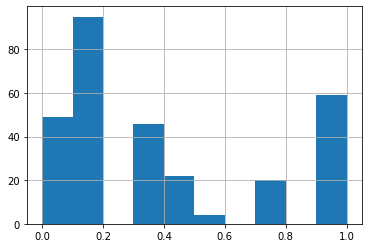

In [132]:
pd.Series(y_predicted_prob[:, 1]).hist()

###ROC curve creation

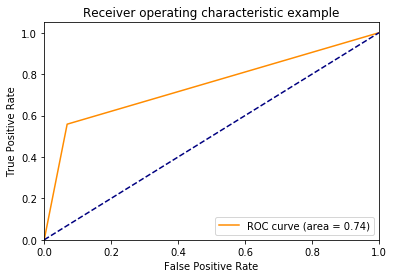

In [139]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

###Decision tree

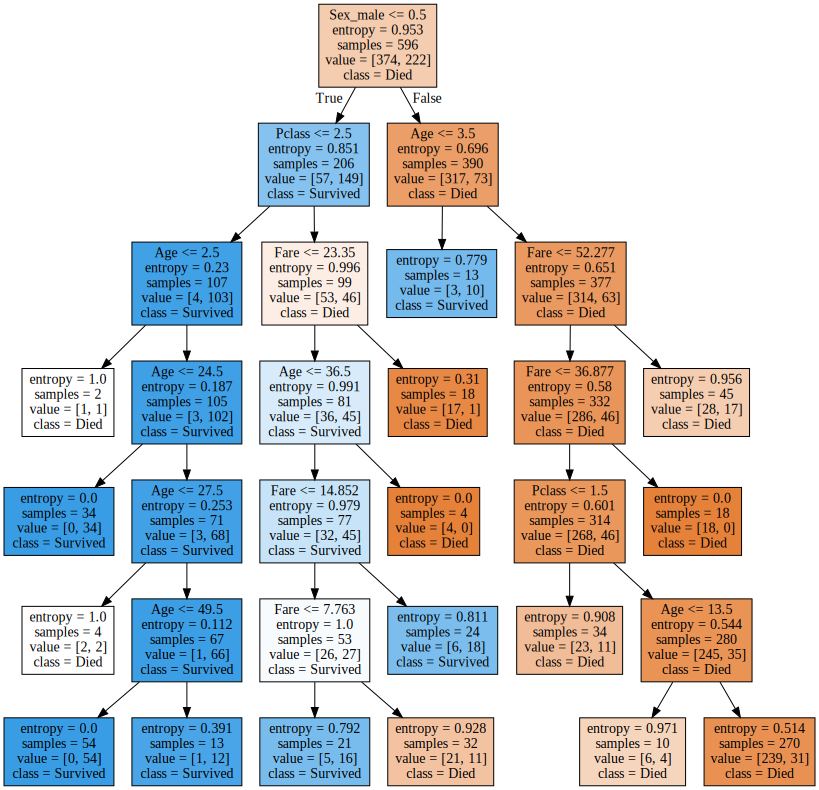

In [141]:
graph = Source(tree.export_graphviz(best_clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Died','Survived'],
                                   filled = True))

display(SVG(graph.pipe(format='svg')))

#########3 training option: Random forest

###Create a classifier for random forest

In [8]:
clf_rf = RandomForestClassifier()

In [9]:
parametrs = {'n_estimators': range(10, 30), 'max_depth': range(1, 30)}

In [10]:
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)

###Random forest training

In [11]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [12]:
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 19}

In [13]:
best_clf = grid_search_cv_clf.best_estimator_

In [164]:
feature_importances = best_clf.feature_importances_

In [165]:
feature_importances_df = pd.DataFrame({'features': list(X_train),
    'feature_importances': feature_importances})

In [166]:
feature_importances_df.sort_values('feature_importances', ascending= False)

,features,feature_importances
6,Sex_male,0.269191
5,Sex_female,0.203805
4,Fare,0.141547
1,Age,0.127545
0,Pclass,0.121584
3,Parch,0.039024
2,SibSp,0.037219
7,Embarked_C,0.026223
9,Embarked_S,0.020441
8,Embarked_Q,0.013421


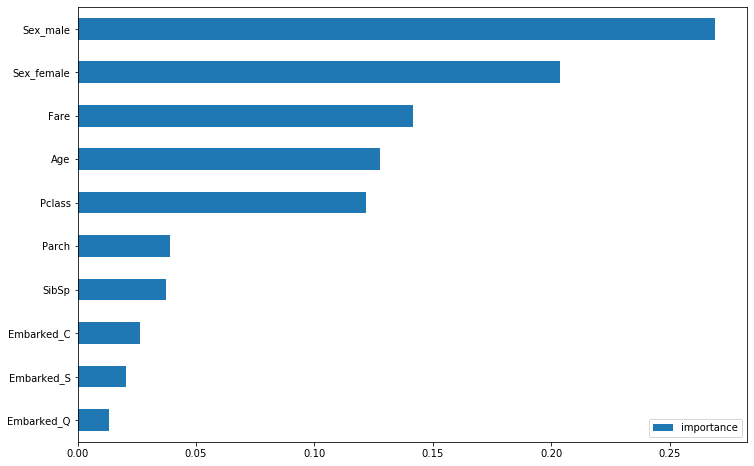

In [169]:
imp = pd.DataFrame(feature_importances, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))